In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [86]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [87]:
#  viewing the configuration and construction of in-memory objects
inspector = inspect(engine)

In [89]:
# Use inspector to view table details
for table_name in inspector.get_table_names():
    for column in inspector.get_columns(table_name):
        print( table_name,": ", column.get('name'), ", ", column.get('type'))

measurement :  id ,  INTEGER
measurement :  station ,  TEXT
measurement :  date ,  TEXT
measurement :  prcp ,  FLOAT
measurement :  tobs ,  FLOAT
station :  id ,  INTEGER
station :  station ,  TEXT
station :  name ,  TEXT
station :  latitude ,  FLOAT
station :  longitude ,  FLOAT
station :  elevation ,  FLOAT


# Exploratory Climate Analysis

In [68]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
lastDate = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(lastDate)

('2017-08-23',)


In [69]:
# Calculate the date 1 year ago from the last data point in the database
previousYear = dt.date(2017, 8, 23) - dt.timedelta(days=365)
print(previousYear)

2016-08-23


In [72]:
# Perform a query to retrieve the data and precipitation scores
precipitation = session.query(Measurement.date,func.avg(Measurement.prcp)).filter(Measurement.date > previousYear).group_by(Measurement.date).all()
# print(precipitation)

In [73]:
# Save the query results as a Pandas DataFrame and set the index to the date column
precipitation_df = pd.DataFrame(precipitation,columns=['date','prcp'])
precipitation_df.set_index('date', inplace=True)
precipitation_df.head(10)

,prcp
date,
2016-08-24,1.555000
2016-08-25,0.077143
2016-08-26,0.016667
2016-08-27,0.064000
2016-08-28,0.516667
2016-08-29,0.243333
2016-08-30,0.011667
2016-08-31,0.636000
2016-09-01,0.006000


In [55]:
# Sort the dataframe by date
new_precipitation_df = precipitation_df.sort_index()
new_precipitation_df.head(10)

,prcp
date,
2016-08-24,1.555000
2016-08-25,0.077143
2016-08-26,0.016667
2016-08-27,0.064000
2016-08-28,0.516667
2016-08-29,0.243333
2016-08-30,0.011667
2016-08-31,0.636000
2016-09-01,0.006000


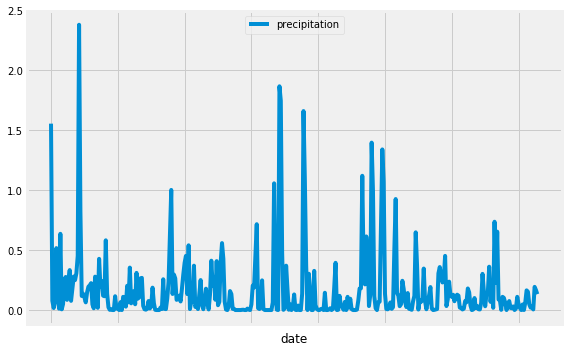

In [65]:
# Use Pandas Plotting with Matplotlib to plot the data
precipitation_df.plot(use_index=True, y='prcp', figsize=(8,5))
plt.xlabel('date')
plt.legend(['precipitation'],loc=9)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


![precipitation](Images/precipitation.png)

In [74]:
# Use Pandas to calcualte the summary statistics for the precipitation data
new_precipitation_df.describe()

,prcp
count,365.000000
mean,0.169987
std,0.295722
min,0.000000
25%,0.008571
50%,0.070000
75%,0.191667
max,2.380000


![describe](Images/describe.png)

In [93]:
# Design a query to show how many stations are available in this dataset?
numStations = session.query(Measurement).group_by(Measurement.station).count()
print(f"There are {numStations} stations available in this dataset.")

There are 9 stations available in this dataset.


In [88]:
# Use inspector to view table details
for table_name in inspector.get_table_names():
    for column in inspector.get_columns(table_name):
        print( table_name,": ", column.get('name'), ", ", column.get('type'))

measurement :  id ,  INTEGER
measurement :  station ,  TEXT
measurement :  date ,  TEXT
measurement :  prcp ,  FLOAT
measurement :  tobs ,  FLOAT
station :  id ,  INTEGER
station :  station ,  TEXT
station :  name ,  TEXT
station :  latitude ,  FLOAT
station :  longitude ,  FLOAT
station :  elevation ,  FLOAT


In [107]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active_station = session.query(Measurement.station,func.count(Measurement.station)).group_by(Measurement.station)\
.order_by(func.count(Measurement.station).desc())
print('Most active stations and counts in descending order')
print('-----------------------')
for row in active_station:
    print(row)

Most active stations and counts in descending order
-----------------------
('USC00519281', 2772)
('USC00519397', 2724)
('USC00513117', 2709)
('USC00519523', 2669)
('USC00516128', 2612)
('USC00514830', 2202)
('USC00511918', 1979)
('USC00517948', 1372)
('USC00518838', 511)


In [125]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
lowest_temp_record = session.query(Station.id, Station.name,func.min(Measurement.tobs))
print(f"The lowest temperature recorded is {lowest_temp_record[0][2]} ")
highest_temp_record = session.query(Station.id, Station.name,func.max(Measurement.tobs))
print(f"The highest temperature recorded is {highest_temp_record[0][2]} ")
avg_temp_most_active = session.query(Station.id,Station.name,func.avg(Measurement.tobs))\
.filter(Measurement.station == Station.station).filter(Measurement.station == "USC00519281")
print(f"The average temperature of most active station {avg_temp_most_active[0][2]} ")

The lowest temperature recorded is 53.0 
The highest temperature recorded is 87.0 
The average temperature of most active station 71.66378066378067 


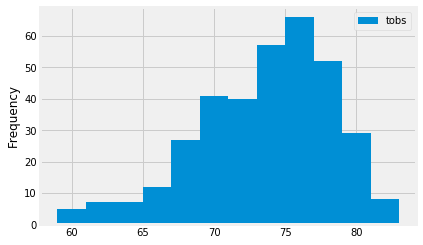

In [129]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
highestTemp = session.query(Measurement.station, Measurement.date, Measurement.tobs).\
filter(Measurement.station == 'USC00519281').filter(Measurement.date > previousYear).order_by(Measurement.date).all()
highestTemp_df=pd.DataFrame(highestTemp)
plt.hist(highestTemp_df['tobs'],12)
plt.ylabel("Frequency")
plt.legend(['tobs'],loc=1)
plt.show()

![precipitation](Images/station-histogram.png)

In [130]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [141]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip_start = dt.date(2018, 1, 14)
trip_end = dt.date(2018, 6, 14)
lastYear = dt.timedelta(days=365)
calc_start_date = trip_start-lastYear
calc_end_date = trip_end-lastYear
tmp_avg_lastYear = calc_temps((calc_start_date),(calc_end_date))
print(tmp_avg_lastYear)

[(58.0, 72.9656652360515, 87.0)]


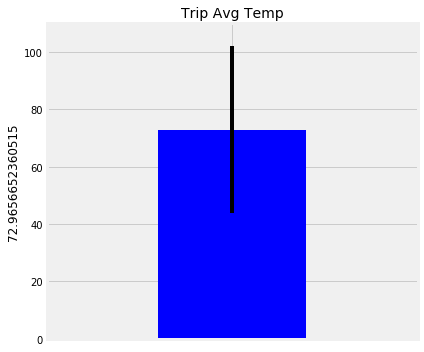

In [142]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
plt.subplots(figsize=(6,5))
plt.xlim(0, 2)
plt.ylim([0,110])
plt.bar(1, tmp_avg_lastYear[0][1], color = 'blue', yerr = tmp_avg_lastYear[0][2]-tmp_avg_lastYear[0][0], tick_label="", align='center')
plt.title(f"Trip Avg Temp", fontsize=14)
plt.ylabel(f"{tmp_avg_lastYear[0][1]}")
plt.tight_layout()

plt.show()

In [151]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
rainfall_weather_station = session.query(Station.station,func.sum(Measurement.prcp),Station.name,Station.elevation,Station.latitude,Station.longitude)\
.filter(Measurement.station == Station.station).filter(Measurement.date >= calc_start_date).filter(Measurement.date <= calc_end_date)\
.group_by(Station.station).order_by(Measurement.prcp.desc())
print(f"Total amount of rainfall per weather station for my trip \n") 
print(f"Calculated Search Dates: {calc_start_date} - {calc_end_date} \n")
print("------------------------------------------------------------ \n")
for row in rainfall_weather_station:
#     print(row)
    print(f"Station: {row[0]} Name: {row[2]}\n")
    print(f"Latitude: {row[3]} Longitude: {row[4]} Elevation: {row[5]} \n")
    print("-------------------------------------------------------------------- \n")

Total amount of rainfall per weather station for my trip 

Calculated Search Dates: 2017-01-14 - 2017-06-14 

------------------------------------------------------------ 

Station: USC00519281 Name: WAIHEE 837.5, HI US

Latitude: 32.9 Longitude: 21.45167 Elevation: -157.84888999999998 

-------------------------------------------------------------------- 

Station: USC00513117 Name: KANEOHE 838.1, HI US

Latitude: 14.6 Longitude: 21.4234 Elevation: -157.8015 

-------------------------------------------------------------------- 

Station: USC00514830 Name: KUALOA RANCH HEADQUARTERS 886.9, HI US

Latitude: 7.0 Longitude: 21.5213 Elevation: -157.8374 

-------------------------------------------------------------------- 

Station: USC00516128 Name: MANOA LYON ARBO 785.2, HI US

Latitude: 152.4 Longitude: 21.3331 Elevation: -157.8025 

-------------------------------------------------------------------- 

Station: USC00517948 Name: PEARL CITY, HI US

Latitude: 11.9 Longitude: 21.3934 Ele

## Optional Challenge Assignment

In [133]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
